## 準備

著者サイトで公開されているデータ(種子数データ)と、UCIで公開されているstudent performance(欠席数データ)を使います。

http://hosho.ees.hokudai.ac.jp/~kubo/ce/IwanamiBook.html

https://archive.ics.uci.edu/ml/datasets/student+performance

In [1]:
import requests
import zipfile
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson

In [2]:
%precision 3

'%.3f'

In [3]:
# 全カラムを表示させる
pd.set_option('display.max_columns', None)

### 種子数データ

In [4]:
# 著者サイトからdata3a.csvをダウンロード
response = requests.get('http://hosho.ees.hokudai.ac.jp/~kubo/stat/iwanamibook/fig/poisson/data3a.csv')
with open ('data3a.csv', 'wb') as f:
    f.write(response.content)
    f.close()

In [5]:
# サンプルデータをロード
data = pd.read_csv('data3a.csv')

### 欠席数データ

In [6]:
# student.zipをダウンロード
response = requests.get('https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip')
with open ('student.zip', 'wb') as f:
    f.write(response.content)
    f.close()

In [7]:
# カレントディレクトリに解凍
zfile = zipfile.ZipFile('student.zip')
zfile.extractall('.')

In [8]:
# 数学の成績(student-mat.csv)をロード
student_math_data = pd.read_csv('student-mat.csv', delimiter=';')
student_math_data = student_math_data[student_math_data['absences'] < 30] # 欠席回数30以上は外れ値として除外

student_math_data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10


In [9]:
# 欠席回数(カウントデータ)を目的変数として使う
# 欠席数の分布が偶数に偏っている
# そこで2で割って切り捨てることで、欠席数0〜1の人は0回、2〜3の人は1回、・・・となるようにする
absences = pd.Series(student_math_data['absences'] / 2, dtype=int) 

# 年齢(age)と恋人がいるかどうか(romantic)を説明変数として使う
age = student_math_data['age']
romantic = student_math_data['romantic']

student_data = pd.concat([absences, age, romantic], axis=1)

## 3.2 観測されたデータの概要を調べる

In [10]:
# 先頭5行の表示
data.head()

,y,x,f
0,6,8.31,C
1,6,9.44,C
2,6,9.50,C
3,12,9.07,C
4,10,10.16,C


In [11]:
# x列の表示
print(data['x'].head())

0     8.31
1     9.44
2     9.50
3     9.07
4    10.16
Name: x, dtype: float64


In [12]:
# f列の表示
print(data['f'].head())

0    C
1    C
2    C
3    C
4    C
Name: f, dtype: object


In [13]:
# dataの型
type(data)

pandas.core.frame.DataFrame

In [14]:
# 各列の型
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
y    100 non-null int64
x    100 non-null float64
f    100 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 2.4+ KB


In [15]:
# fの値の分布
data['f'].value_counts()

T    50
C    50
Name: f, dtype: int64

In [16]:
# y列とx列の要約統計量
data.describe()

,y,x
count,100.000000,100.000000
mean,7.830000,10.089100
std,2.624881,1.008049
min,2.000000,7.190000
25%,6.000000,9.427500
50%,8.000000,10.155000
75%,10.000000,10.685000
max,15.000000,12.400000


In [17]:
# f列の概要
data['f'].value_counts()

T    50
C    50
Name: f, dtype: int64

### 欠席数データ

In [18]:
# 先頭5行の表示
student_data.head()

,absences,age,romantic
0,3,18,no
1,2,17,no
2,5,15,no
3,1,15,yes
4,2,16,no


In [19]:
# 各列の型
student_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 3 columns):
absences    389 non-null int64
age         389 non-null int64
romantic    389 non-null object
dtypes: int64(2), object(1)
memory usage: 12.2+ KB


In [20]:
student_data['age'].value_counts()

16    103
17     96
15     82
18     81
19     22
20      3
22      1
21      1
Name: age, dtype: int64

In [21]:
student_data['romantic'].value_counts()

no     262
yes    127
Name: romantic, dtype: int64

## 3.3 統計モデリングの前にデータを図示する

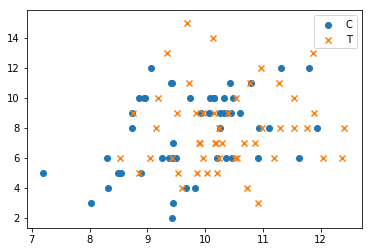

In [22]:
# 散布図
plt.scatter(data[data['f']=='C']['x'], data[data['f']=='C']['y'], marker='o', label='C')
plt.scatter(data[data['f']=='T']['x'], data[data['f']=='T']['y'], marker='x', label='T')
plt.legend(loc='best')
plt.show()

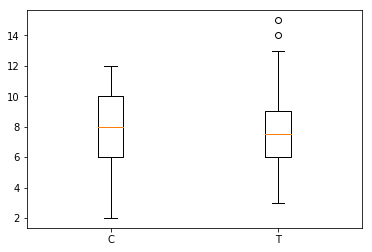

In [23]:
# 箱ひげ図
fig, ax = plt.subplots()
ax.boxplot([data[data['f']=='C']['y'], data[data['f']=='T']['y']])
ax.set_xticklabels(['C', 'T'])
plt.show()

### 欠席数データ

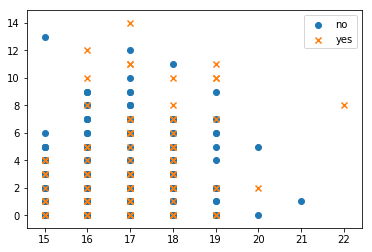

In [24]:
# 散布図
plt.scatter(student_data[student_data['romantic']=='no']['age'], student_data[student_data['romantic']=='no']['absences'], marker='o', label='no')
plt.scatter(student_data[student_data['romantic']=='yes']['age'], student_data[student_data['romantic']=='yes']['absences'], marker='x', label='yes')
plt.legend(loc='best')
plt.show()

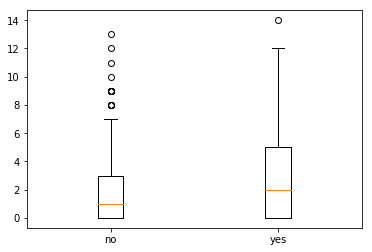

In [25]:
# 箱ひげ図
fig, ax = plt.subplots()
ax.boxplot([student_data[student_data['romantic']=='no']['absences'], student_data[student_data['romantic']=='yes']['absences']])
ax.set_xticklabels(['no', 'yes'])
plt.show()

## 3.4 ポアソン回帰の統計モデル

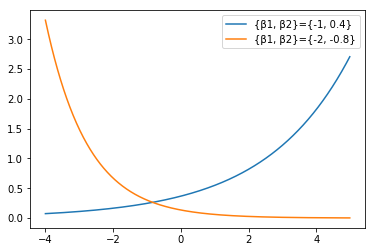

In [26]:
# λとexp(β1+β2x)の関係
x = np.arange(-4, 5, 0.01)
lam1 = [math.exp(-1 + 0.4*x_i) for x_i in x]
lam2 = [math.exp(-2 + -(0.8*x_i)) for x_i in x]

plt.plot(x, lam1, label='{β1, β2}={-1, 0.4}')
plt.plot(x, lam2, label='{β1, β2}={-2, -0.8}')
plt.legend(loc='best')

plt.show()

In [27]:
import statsmodels.formula.api as smf


results = smf.poisson('y ~ x', data=data).fit()

results.summary()

Optimization terminated successfully.
         Current function value: 2.353863
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                        Poisson   Df Residuals:                       98
Method:                           MLE   Df Model:                            1
Date:                Thu, 25 Jan 2018   Pseudo R-squ.:                0.009497
Time:                        21:04:30   Log-Likelihood:                -235.39
converged:                       True   LL-Null:                       -237.64
                                        LLR p-value:                   0.03362
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.2917      0.364      3.552      0.000         0.579     2.005
x              0.0757      0.036      2.125      0.034         0.006     0.145
==============================================================================
"""

In [28]:
import statsmodels.api as sm

results = sm.Poisson(data['y'], sm.add_constant(data['x'])).fit()
#results = sm.GLM(data['y'], sm.add_constant(data['x']), family=sm.families.Poisson()).fit()

results.summary()

Optimization terminated successfully.
         Current function value: 2.353863
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                        Poisson   Df Residuals:                       98
Method:                           MLE   Df Model:                            1
Date:                Thu, 25 Jan 2018   Pseudo R-squ.:                0.009497
Time:                        21:04:35   Log-Likelihood:                -235.39
converged:                       True   LL-Null:                       -237.64
                                        LLR p-value:                   0.03362
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          1.2917      0.364      3.552      0.000         0.579     2.005
x              0.0757      0.036      2.125      0.034         0.006     0.145
==============================================================================
"""

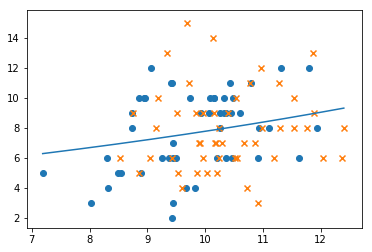

In [29]:
# 散布図
plt.scatter(data[data['f']=='C']['x'], data[data['f']=='C']['y'], marker='o', label='C')
plt.scatter(data[data['f']=='T']['x'], data[data['f']=='T']['y'], marker='x', label='T')

# λの予測値
x = np.arange(data['x'].min(), data['x'].max() + 0.01, 0.01)
y = [math.exp(results.params['const'] + results.params['x'] * x_i)  for x_i in x]
plt.plot(x, y)

plt.show()

### 欠席数データ

In [30]:
results = smf.poisson('absences ~ age', data=student_data).fit()

results.summary()

Optimization terminated successfully.
         Current function value: 2.526199
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:               absences   No. Observations:                  389
Model:                        Poisson   Df Residuals:                      387
Method:                           MLE   Df Model:                            1
Date:                Thu, 25 Jan 2018   Pseudo R-squ.:                 0.01418
Time:                        21:04:47   Log-Likelihood:                -982.69
converged:                       True   LL-Null:                       -996.83
                                        LLR p-value:                 1.051e-07
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -1.3029      0.414     -3.149      0.002        -2.114    -0.492
age            0.1315      0.024      5.386      0.000         0.084     0.179
==============================================================================
"""

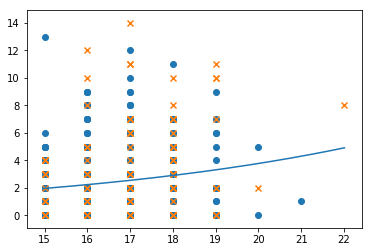

In [31]:
# 散布図
plt.scatter(student_data[student_data['romantic']=='no']['age'], student_data[student_data['romantic']=='no']['absences'], marker='o', label='no')
plt.scatter(student_data[student_data['romantic']=='yes']['age'], student_data[student_data['romantic']=='yes']['absences'], marker='x', label='yes')

# λの予測値
x = np.arange(student_data['age'].min(), student_data['age'].max() + 0.01, 0.01)
y = [math.exp(results.params['Intercept'] + results.params['age'] * x_i)  for x_i in x]
plt.plot(x, y)

plt.show()

## 3.5 説明変数が因子型の統計モデル

In [32]:
# f=Tの場合に1となる列d(ダミー変数)を追加
data['d'] = pd.get_dummies(data['f'])['T']

data.head()

,y,x,f,d
0,6,8.31,C,0
1,6,9.44,C,0
2,6,9.50,C,0
3,12,9.07,C,0
4,10,10.16,C,0


In [33]:
results = smf.poisson('y ~ d', data=data).fit()

results.summary()

Optimization terminated successfully.
         Current function value: 2.376273
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                        Poisson   Df Residuals:                       98
Method:                           MLE   Df Model:                            1
Date:                Thu, 25 Jan 2018   Pseudo R-squ.:               6.718e-05
Time:                        21:05:02   Log-Likelihood:                -237.63
converged:                       True   LL-Null:                       -237.64
                                        LLR p-value:                    0.8582
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      2.0516      0.051     40.463      0.000         1.952     2.151
d              0.0128      0.071      0.179      0.858        -0.127     0.153
==============================================================================
"""

### 欠席数データ

In [34]:
student_data['d'] = pd.get_dummies(student_data['romantic'])['yes']

In [35]:
results = smf.poisson('absences ~ d', data=student_data).fit()

results.summary()

Optimization terminated successfully.
         Current function value: 2.548144
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:               absences   No. Observations:                  389
Model:                        Poisson   Df Residuals:                      387
Method:                           MLE   Df Model:                            1
Date:                Thu, 25 Jan 2018   Pseudo R-squ.:                0.005620
Time:                        21:05:05   Log-Likelihood:                -991.23
converged:                       True   LL-Null:                       -996.83
                                        LLR p-value:                 0.0008163
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.8252      0.041     20.181      0.000         0.745     0.905
d              0.2250      0.067      3.381      0.001         0.095     0.355
==============================================================================
"""

## 3.6 説明変数が数量型＋因子型の統計モデル

In [36]:
results = smf.poisson('y ~ x+d', data=data).fit()

results.summary()

Optimization terminated successfully.
         Current function value: 2.352937
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                        Poisson   Df Residuals:                       97
Method:                           MLE   Df Model:                            2
Date:                Thu, 25 Jan 2018   Pseudo R-squ.:                0.009887
Time:                        21:05:09   Log-Likelihood:                -235.29
converged:                       True   LL-Null:                       -237.64
                                        LLR p-value:                   0.09542
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.2631      0.370      3.417      0.001         0.539     1.988
x              0.0801      0.037      2.162      0.031         0.007     0.153
d             -0.0320      0.074     -0.430      0.667        -0.178     0.114
==============================================================================
"""

### 欠席数データ

In [37]:
results = smf.poisson('absences ~ age+d', data=student_data).fit()

results.summary()

Optimization terminated successfully.
         Current function value: 2.517617
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:               absences   No. Observations:                  389
Model:                        Poisson   Df Residuals:                      386
Method:                           MLE   Df Model:                            2
Date:                Thu, 25 Jan 2018   Pseudo R-squ.:                 0.01753
Time:                        21:05:13   Log-Likelihood:                -979.35
converged:                       True   LL-Null:                       -996.83
                                        LLR p-value:                 2.569e-08
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -1.2045      0.416     -2.895      0.004        -2.020    -0.389
age            0.1219      0.025      4.932      0.000         0.073     0.170
d              0.1752      0.067      2.603      0.009         0.043     0.307
==============================================================================
"""